In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF, batched_Matern32
from gpzoo.gp import GaussianPrior, batched_WSVGP
from gpzoo.likelihoods import PNMF, NSF2, batched_Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


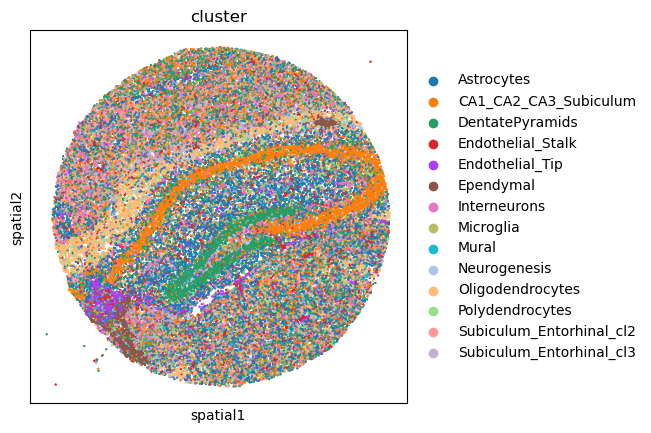

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

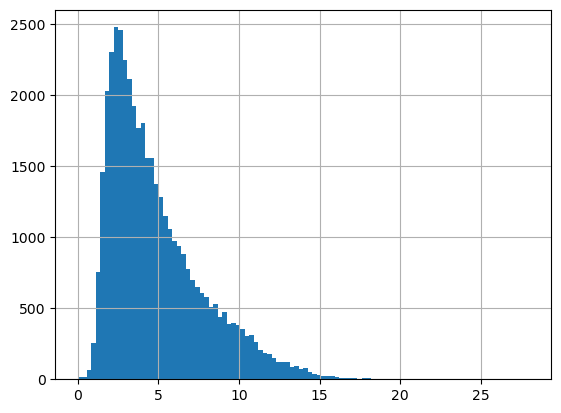

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [8]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [9]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [10]:
Y.shape

(17702, 39694)

In [11]:
nmf_model = NMF(n_components=24, max_iter=100, init='random', random_state=528, alpha_H=1e-4)

In [12]:
nmf_model.fit(Y.T/V)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.0001, init='random', max_iter=100, n_components=24,
    random_state=528)

In [13]:
exp_factors = nmf_model.transform(Y.T/V)
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [14]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [15]:
moranI

array([0.75610457, 0.73049739, 0.6267765 , 0.58123646, 0.54343106,
       0.5420599 , 0.51559362, 0.46014162, 0.37050834, 0.34999975,
       0.33939117, 0.3042353 , 0.29175853, 0.2845773 , 0.28375111,
       0.2799855 , 0.26693338, 0.22651752, 0.17907814, 0.14991427,
       0.14465869, 0.08677173, 0.08029446, 0.03586282])

In [16]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

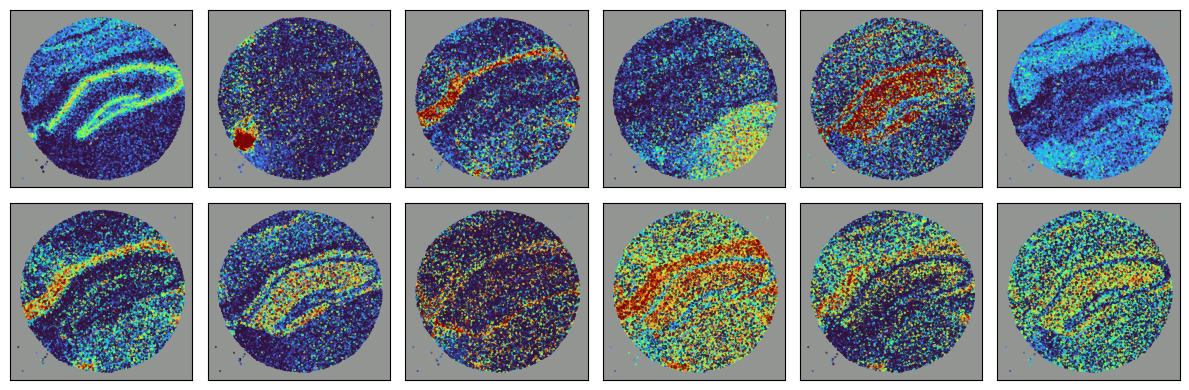

In [17]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[:12], ax=None, size=2, s=0.2, alpha=0.9)

In [18]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

In [19]:
def build_model(Y, L=12):
    

    
    # idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    M = len(X)
    Z = nn.Parameter(X)
    
    kernel = batched_Matern32(sigma=[1.0]*L, lengthscale=[2.0]*L)
    gp = batched_WSVGP(kernel, M=M, jitter=1e-2)
    
    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)

    
    
    mu = all_factors

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    prior = GaussianPrior(Y, L=L)
    prior.mean = nn.Parameter(torch.squeeze(torch.tensor(factors_ordered[:, L:].T)).clone().detach()).type(torch.float)

    

    model = batched_Hybrid_NSF2(gp, prior, Y, L=L, T=L)


    model.sf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, :L]).type(torch.float)) 
    model.cf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, L:]).type(torch.float)) 


    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float))) 
    
    model.to(device)
    return model

In [20]:
def build_model_scratch(Y, M=1000, L=10):
    

    
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    Z = nn.Parameter(X[idx])
    
    kernel = batched_Matern32(sigma=[1.0]*L, lengthscale=[2.0]*L)
    gp = WSVGP(kernel, M=M, jitter=1e-2)
    gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    prior = GaussianPrior(Y, L=L)

    model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)
    
    model.to(device)
    return model

In [21]:
model = build_model(Y)

here


OutOfMemoryError: CUDA out of memory. Tried to allocate 70.44 GiB. GPU 1 has a total capacity of 23.50 GiB of which 23.26 GiB is free. Including non-PyTorch memory, this process has 226.00 MiB memory in use. Of the allocated memory 311.50 KiB is allocated by PyTorch, and 1.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# model.load_state_dict(torch.load('slideseq_12_factors.pth'))

In [ ]:
model.cpu()
mean = torch.exp(model.sf.prior.mu).detach().numpy()

In [ ]:
plot_factors(mean, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [ ]:
# in case of nans, replace with random number.
# this rarely happens but it's useful to have a function to handle it.
# with torch.no_grad():
#     model.sf.prior.mu[4].view(-1)[:] = torch.randn(len(model.sf.prior.mu[4]))

In [ ]:
moran_idx, moranI = dims_autocorr(mean.T, X)
moranI

In [ ]:
X_train = X.to(device)
Y_train = Y.to(device)

In [ ]:
def model_grads(model):
    model.sf.prior.kernel.sigma.requires_grad = False
    model.sf.prior.kernel.lengthscale.requires_grad = False
    model.sf.prior.Z.requires_grad=False
    model.sf.prior.mu.requires_grad=True
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=True

    model.cf.prior.mean.requires_grad=True
    model.cf.prior.scale.requires_grad=True
    model.cf.W.requires_grad=True

    model.cf.prior.scale_pf = 0.5
    
    
    model.V.requires_grad=False

In [ ]:
model_grads(model)

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [ ]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU, qF2, pF2 = model.forward_batched(X=X, idx=idx, E=E, **kwargs)
        pU.mean.to(device)
        pU.scale_tril.to(device)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        ELBO -= torch.sum(distributions.kl_divergence(qF2, pF2))
        loss = -ELBO

        loss += 20.0*torch.sum(model.sf.prior.kernel.lengthscale**2) 
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [ ]:
steps = int(10)
model.to(device)

In [ ]:
model.sf.prior.jitter=1e-6

In [ ]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3, batch_size=1000)

In [246]:
# torch.save(model.state_dict(), 'slideseq_12_factors.pth')

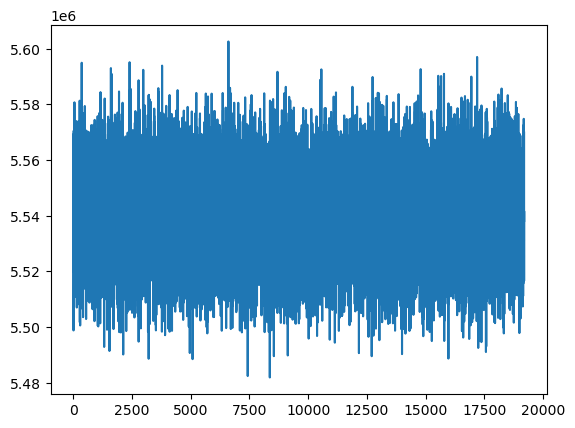

In [226]:
plt.plot(losses)

In [227]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([6.4781, 6.1887, 6.7455, 7.7124, 6.2731, 6.4016, 4.3409, 7.3197, 4.9378,
        6.0576, 7.9257, 4.5571], device='cuda:1', requires_grad=True)

In [216]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([5.8646, 4.8669, 5.0770, 6.1599, 5.7440, 4.7660, 3.0875, 3.9933, 3.8164,
        4.0000, 5.5048, 3.1192], device='cuda:1')

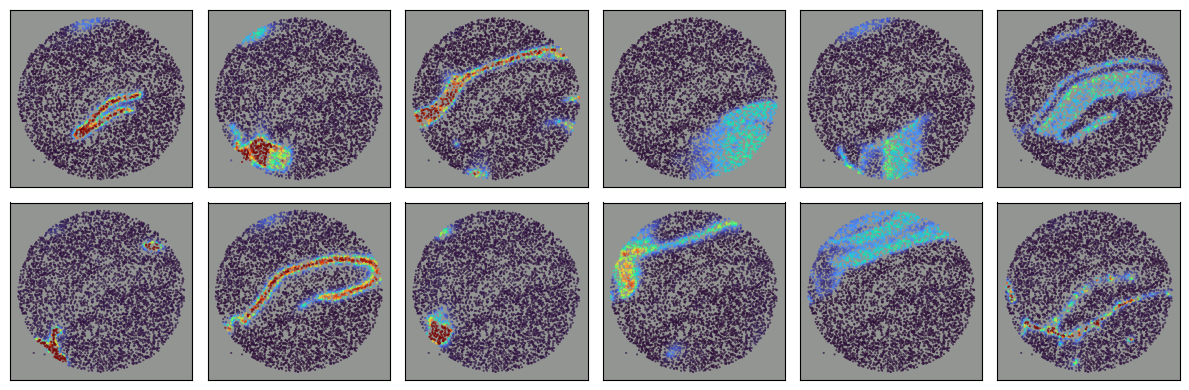

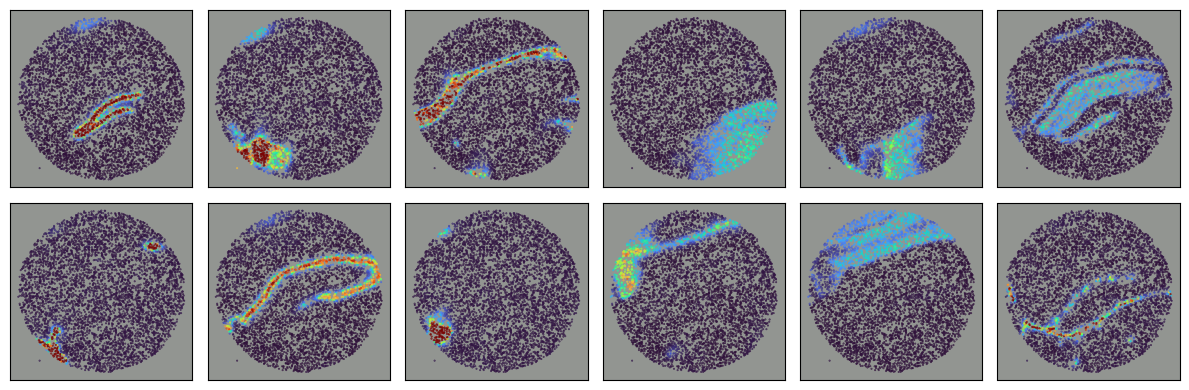

In [242]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)


In [243]:
model.cpu()

qF2, _ = model.cf.prior()
means2 = torch.exp(qF2.mean).detach().numpy()

In [244]:
moran_idx, moranI = dims_autocorr(means2.T, X)
moranI

here_andata


array([ 4.21130411e-01,  4.15461663e-01,  3.18776012e-01,  3.02088723e-01,
        2.55533892e-01,  1.86482377e-01,  1.80133427e-01,  6.17489108e-02,
        2.07366313e-02,  2.74930474e-05, -5.35310483e-04, -6.33984458e-04])

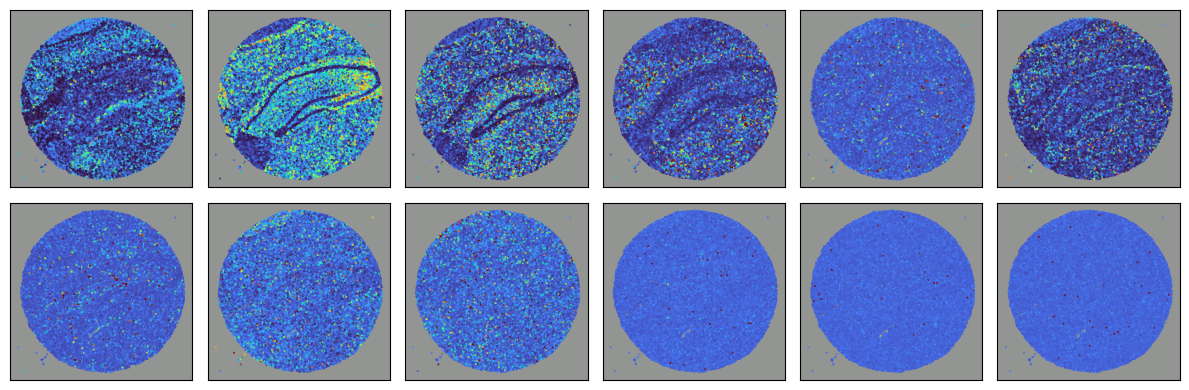

In [245]:
plot_factors(means2, X, moran_idx=moran_idx, ax=None, size=2, s=0.2, alpha=0.9)


In [ ]:
# size=2
# fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)


# def update(iteration):
#     for element in ax:
#         for element in element:
#             element.cla()
        
#     curr_factor = means[iteration]

    
    
#     plot_factors(curr_factor, X, ax=ax, size=2, s=0.6, alpha=1)

# #     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
# #     fig.tight_layout()
#     print('hi', iteration)


# anim = FuncAnimation(fig, update, frames=np.arange(0, 600, 1), interval=100)
# plt.close()z
# # anim.save('pnmf.mp4',
# #          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
# #          dpi=50)
# anim.save("visium_vnngp.mp4", fps=60, dpi=100)